In [1]:
from helper_fun import *

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Using tensorflow version: 2.5.0-rc2


#### This time we are going to use pre-trained models available at [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

_dataset used is [10_food_classes_10_percent](https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip)_


```
unzip_data('../10_food_classes_10_percent.zip')
unzip_data('../10_food_classes_1_percent.zip')
```

In [49]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [2]:
def build_train_test_data(train_dir, test_dir, image_size = (224,224), batch_size = 32, seed = 42):
    
    train_dir = train_dir
    test_dir = test_dir
    

    train_data = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir,
                                                                    image_size = image_size,
                                                                    batch_size = batch_size,
                                                                    label_mode = 'categorical',
                                                                    seed = seed)

    test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir,
                                                                   image_size = image_size,
                                                                   batch_size = batch_size,
                                                                   label_mode = 'categorical',
                                                                   seed = seed)
    
    
    return train_data, test_data

In [3]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
RANDOM_SEED = 42

train_data, test_data = build_train_test_data(train_dir= '10_food_classes_10_percent/train/',
                                              test_dir= '10_food_classes_10_percent/test/', 
                                              image_size= IMAGE_SIZE, 
                                              batch_size= BATCH_SIZE, 
                                              seed= RANDOM_SEED)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### 1. Create model using tensorflow Functional API


**Creating base model with EfficientNet**

In [6]:
# Initialize EfficientNetB0 model from tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top= False)

# Freeze the base model (so the underlying learned patterns don't change)
base_model.trainable = False

# Create input to the model
inputs = tf.keras.layers.Input(shape= IMAGE_SIZE + (3,), name= 'input_layer')

# Normalize the inputs
# This step is not required here as EfficientNet has rescaling built-in but will be needed for other models
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)  

# Pass the inputs to base model
x = base_model(inputs)
print(f'Shape of x after passing inputs to model: {x.shape}')

# Average pool the outputs of base model
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_avg_pooling_layer')(x)
print(f'Shape of x after global pool operation: {x.shape}')

# Create the output activation layer
output = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# Combine the inputs and outputs into the model
model_1 = tf.keras.Model(inputs, output)

# Compile the model
model_1.compile(loss = CategoricalCrossentropy(),
               optimizer = Adam(),
               metrics = ['accuracy'])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs = 5,
                        steps_per_epoch= len(train_data),
                        validation_data= test_data,
                        validation_steps= 0.25*len(test_data),
                        callbacks = [create_tensorboard_callback('logs/', 'fine_tuning_model_1')])

Shape of x after passing inputs to model: (None, 7, 7, 1280)
Shape of x after global pool operation: (None, 1280)
Saving tensorboard log files to logs/fine_tuning_model_1\20210526_182817


c:\users\abprakash\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5
24/24 [==============================] - 74s 3s/step - loss: 1.9603 - accuracy: 0.3747 - val_loss: 1.3542 - val_accuracy: 0.7297
Epoch 2/5
24/24 [==============================] - 62s 3s/step - loss: 1.1812 - accuracy: 0.7333 - val_loss: 0.9081 - val_accuracy: 0.8078
Epoch 3/5
24/24 [==============================] - 60s 3s/step - loss: 0.8564 - accuracy: 0.8093 - val_loss: 0.7194 - val_accuracy: 0.8453
Epoch 4/5
24/24 [==============================] - 59s 3s/step - loss: 0.7085 - accuracy: 0.8427 - val_loss: 0.6286 - val_accuracy: 0.8547
Epoch 5/5
24/24 [==============================] - 60s 3s/step - loss: 0.6107 - accuracy: 0.8640 - val_loss: 0.5983 - val_accuracy: 0.8469


In [68]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 244, 244, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pooling_layer (Gl (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [69]:
# Evaluate on full test dataset

model_1.evaluate(test_data)

79/79 [==============================] - 134s 2s/step - loss: 0.5958 - accuracy: 0.8468


[0.5957906246185303, 0.8468000292778015]

In [70]:
for layer_num, layer in enumerate(base_model.layers):
    print(layer_num, layer.name)

0 input_4
1 rescaling_3
2 normalization_3
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [71]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, None, None, 3 7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_3[0][0]            
_____________________________________________________________________________________

In [72]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 244, 244, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pooling_layer (Gl (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


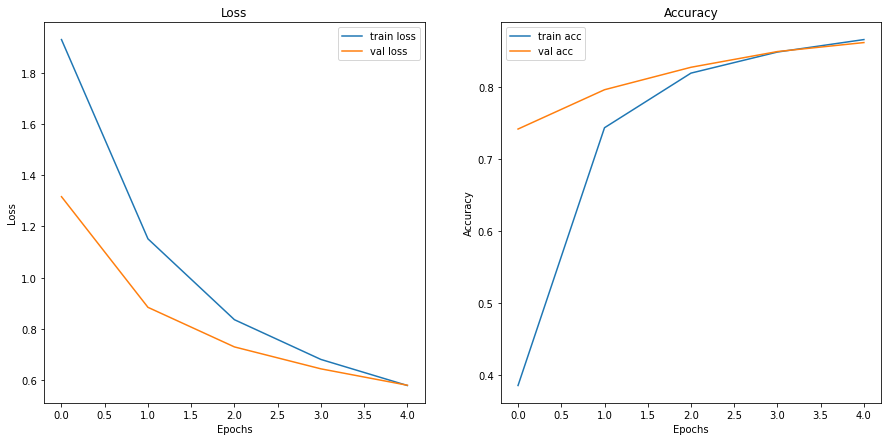

In [73]:
plot_history(history_1)

### Getting feature vector from trained model

GlobalAveragePooling2D: It transforms a 4-D tensor to 2-D tensor

In [98]:
tf.random.set_seed(42)

input_shape = (1,4,4,3)

input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor: \n{input_tensor}')

# Pass random tensor through Global Average Pooling layer
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f'\nShape of input_tensor: {input_tensor.shape}')
print(f'\nGlobal avg pool tensor: {global_avg_pool}')
print(f'\nShape of global avg pooled tensor {global_avg_pool.shape}')

Random input tensor: 
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

Shape of input_tensor: (1, 4, 4, 3)

Global avg pool tensor: [[-0.09368646 -0.45840445 -0.28855976]]

Shape of global avg pooled tensor (1, 3)


In [102]:
tf.reduce_mean(input_tensor, axis= [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

In [103]:
tf.reduce_max(input_tensor, axis= [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

### Running a series of experiments

_**Note:** Throughout the experiments, same test dataset will be used_

1. Use feature extarction transfer learning with 1% of training data with data augmentation
2. Use feature extraction transfer learning with 10% of training data with data augmentation
3. Use fine-tuning transfer learning on 10% of training data with data augmentation
4. Use fine-tuning transfer learning on 100% of training data with data augmentation

##### Use feature extarction transfer learning with 1% of training data with data augmentation

In [54]:
train_data_1_per, test_data = build_train_test_data('10_food_classes_1_percent/train/',
                                                    '10_food_classes_1_percent/test/',
                                                     image_size= IMAGE_SIZE,
                                                     batch_size= BATCH_SIZE,
                                                     seed= RANDOM_SEED)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# Adding data augmentation right into the model
# To add augmentation right into the model we can use the layers inside 
# tf.keras.layers.experimental.preprocessing()


# Create data augmentation layer with horizontal flipping, zoom, shear, etc.

data_augmentation = Sequential(layers = [
                                        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                                        tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
                                        tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
                                        tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1./255)
                                        ],
                                name = 'data_augmentation')

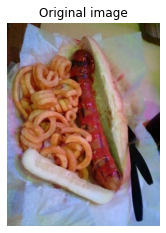

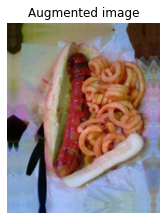

In [35]:
# PLotting some augmented images
img = mpimg.imread('10_food_classes_1_percent/train/chicken_wings/1528703.jpg')
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis(False)
plt.show()

plt.subplot(1,2,2)
img_aug = data_augmentation(tf.expand_dims(img, axis=0))

plt.imshow(tf.squeeze(img_aug))
plt.title('Augmented image')
plt.axis(False)
plt.show()


In [55]:
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape= IMAGE_SIZE + (3,), name= 'input_layer')

x = data_augmentation(inputs)

# Give base_model the inputs and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_avg_pool_layer')(x)

# Put a dense layer as output
outputs = Dense(10, activation = 'softmax', name = 'output_layer')(x)

# Make model using input and output layer
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss = CategoricalCrossentropy(),
               optimizer = Adam(),
               metrics = ['accuracy'])

history_2 = model_2.fit(train_data_1_per, 
                        epochs = 5,
                        steps_per_epoch = len(train_data_1_per),
                        validation_data = test_data,
                        validation_steps = 0.25*len(test_data),
                        callbacks = [create_tensorboard_callback(dir_name= 'logs/', experiment_name= '1_perc_data_aug')])

Saving tensorboard log files to logs/1_perc_data_aug\20210526_210913
Epoch 1/5


c:\users\abprakash\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


3/3 [==============================] - 46s 20s/step - loss: 2.3335 - accuracy: 0.0571 - val_loss: 2.3102 - val_accuracy: 0.1109
Epoch 2/5
3/3 [==============================] - 33s 16s/step - loss: 2.3120 - accuracy: 0.1000 - val_loss: 2.3060 - val_accuracy: 0.1172
Epoch 3/5
3/3 [==============================] - 31s 15s/step - loss: 2.3693 - accuracy: 0.1000 - val_loss: 2.3066 - val_accuracy: 0.1109
Epoch 4/5
3/3 [==============================] - 33s 16s/step - loss: 2.3545 - accuracy: 0.1000 - val_loss: 2.3046 - val_accuracy: 0.1219
Epoch 5/5
3/3 [==============================] - 33s 16s/step - loss: 2.3355 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1187


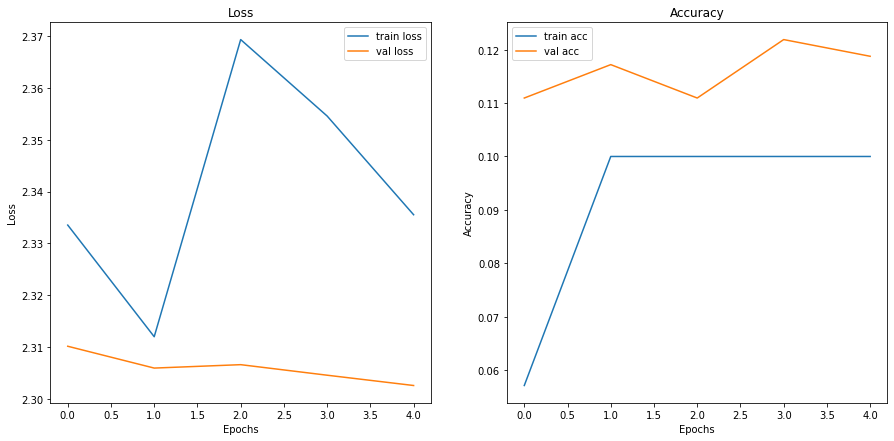

In [56]:
plot_history(history_2)

In [57]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


#### Use feature extraction transfer learning with 10% of training data with data augmentation

In [4]:
train_data_10_per, test_data = build_train_test_data('10_food_classes_10_percent/train/', '10_food_classes_10_percent/test/')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
data_augmentation = Sequential(layers = [
                                            tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                            tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
                                            tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
                                            tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                            tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                                            tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1./255)
                                        ],
                              name = 'data_augmentation_layer')



In [6]:
base_model = tf.keras.applications.EfficientNetB2(include_top= False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = IMAGE_SIZE + (3,), name= 'input_layer')

x = data_augmentation(inputs)

x = base_model(x, training = False)

x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_avg_pool_layer')(x)

outputs = Dense(10, activation = 'softmax', name = 'output_layer')(x)

model_3 = tf.keras.Model(inputs, outputs, name = 'model_3')

model_3.compile(loss = CategoricalCrossentropy(),
               optimizer = Adam(),
               metrics = ['accuracy'])



In [7]:
# Creating model checkpoint callback

def create_model_checkpoint_callback(dir_name, experiment_name):
    
    dir_path = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime('%Y%m%d_%H%M'))
    print(f'Model checkpoint saved at location: {dir_path}')
    
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= dir_path,
                                                         save_best_only=False,
                                                         save_weights_only = True,
                                                         save_freq = 'epoch')
    
    return model_checkpoint

In [8]:
model_ckpt = create_model_checkpoint_callback('checkpoints/', '10_perc_data_aug')
tb_ckpt = create_tensorboard_callback('logs/', '10_perc_data_aug')

history_3 = model_3.fit(train_data_10_per,
                       epochs = 5,
                       steps_per_epoch = len(train_data_10_per),
                       validation_data = test_data,
                       validation_steps = int(0.05*len(test_data)),
                       callbacks = [model_ckpt, tb_ckpt])

Model checkpoint saved at location: checkpoints/10_perc_data_aug\20210526_2143
Saving tensorboard log files to logs/10_perc_data_aug\20210526_214359
Epoch 1/5


c:\users\abprakash\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


24/24 [==============================] - 69s 3s/step - loss: 2.3664 - accuracy: 0.0947 - val_loss: 2.3203 - val_accuracy: 0.1042
Epoch 2/5
24/24 [==============================] - 52s 2s/step - loss: 2.3537 - accuracy: 0.0800 - val_loss: 2.3140 - val_accuracy: 0.0729
Epoch 3/5
24/24 [==============================] - 54s 2s/step - loss: 2.3300 - accuracy: 0.0920 - val_loss: 2.3118 - val_accuracy: 0.1250
Epoch 4/5
24/24 [==============================] - 58s 2s/step - loss: 2.3402 - accuracy: 0.1000 - val_loss: 2.3282 - val_accuracy: 0.0729
Epoch 5/5
24/24 [==============================] - 54s 2s/step - loss: 2.3384 - accuracy: 0.0920 - val_loss: 2.2904 - val_accuracy: 0.1562
